In [ ]:
!pip install kaggle

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

# Path to the folder containing kaggle.json in Google Drive
drive_folder_path = '/content/drive/MyDrive/'

# Create ~/.kaggle/ directory if it doesn't exist
os.makedirs('/root/.kaggle/', exist_ok=True)

# Copy kaggle.json to ~/.kaggle/
shutil.copy(drive_folder_path + 'kaggle.json', '/root/.kaggle/')



'/root/.kaggle/kaggle.json'

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d adityajn105/flickr30k

100% 8.16G/8.16G [00:48<00:00, 203MB/s]
100% 8.16G/8.16G [00:48<00:00, 181MB/s]


In [ ]:
!apt install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
!unzip flickr30k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/flickr30k_images/5354911151.jpg  
  inflating: Images/flickr30k_images/535529555.jpg  
  inflating: Images/flickr30k_images/5356236664.jpg  
  inflating: Images/flickr30k_images/5356318668.jpg  
  inflating: Images/flickr30k_images/535830521.jpg  
  inflating: Images/flickr30k_images/5359437945.jpg  
  inflating: Images/flickr30k_images/5361355399.jpg  
  inflating: Images/flickr30k_images/53614287.jpg  
  inflating: Images/flickr30k_images/536147209.jpg  
  inflating: Images/flickr30k_images/5361551308.jpg  
  inflating: Images/flickr30k_images/536156200.jpg  
  inflating: Images/flickr30k_images/5362687336.jpg  
  inflating: Images/flickr30k_images/5363528971.jpg  
  inflating: Images/flickr30k_images/5363903246.jpg  
  inflating: Images/flickr30k_images/5364849864.jpg  
  inflating: Images/flickr30k_images/536495604.jpg  
  inflating: Images/flickr30k_images/5365075444.jpg  
  inflating: Images/flickr30k_images/5

# Data Exploration

In [ ]:
# Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud

# Load captions file
captions_file_path = 'captions.txt'
captions_df = pd.read_csv(captions_file_path, delimiter=',', header=None, names=['ImageID', 'Caption'])

# Display the first few rows of the captions dataframe
captions_df.head()

,ImageID,Caption
0,image,caption
1,1000092795.jpg,Two young guys with shaggy hair look at their...
2,1000092795.jpg,"Two young , White males are outside near many..."
3,1000092795.jpg,Two men in green shirts are standing in a yard .
4,1000092795.jpg,A man in a blue shirt standing in a garden .


In [ ]:
# Check for null values in the "Caption" column
null_count = captions_df['Caption'].isnull().sum()

# Display the result
print(f"Number of null values in 'Caption' column: {null_count}")

Number of null values in 'Caption' column: 1


In [ ]:
# Drop rows with null values in the "Caption" column
captions_df = captions_df.dropna(subset=['Caption'])

In [ ]:
# Check for null values in the "Caption" column
null_count = captions_df['Caption'].isnull().sum()

# Display the result
print(f"Number of null values in 'Caption' column: {null_count}")

Number of null values in 'Caption' column: 0


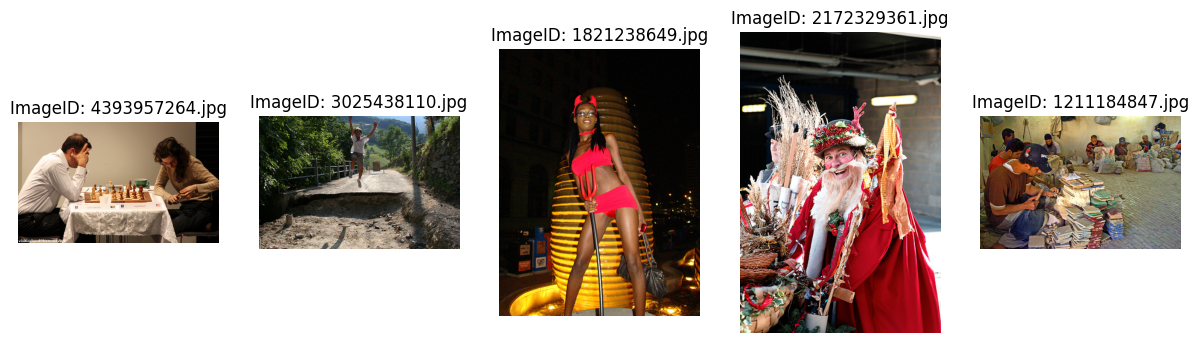

In [ ]:
# Define the directory containing the images
images_dir = 'Images'

# Display some sample images
sample_images = captions_df['ImageID'].sample(5).tolist()

plt.figure(figsize=(15, 8))
for i, img_id in enumerate(sample_images, 1):
    img_path = os.path.join(images_dir, img_id)
    img = Image.open(img_path)

    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(f"ImageID: {img_id}")
    plt.axis('off')

plt.show()

Number of unique images: 31784
Number of unique captions: 158439


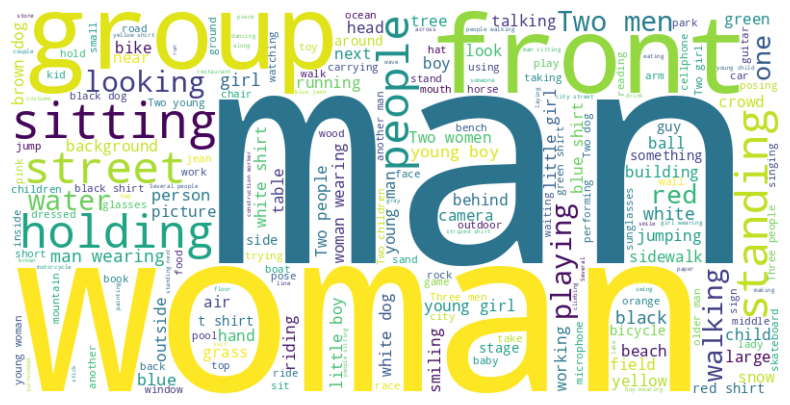

In [ ]:
# Convert 'Caption' column to strings
captions_df['Caption'] = captions_df['Caption'].astype(str)

# Calculate the number of unique images and unique captions
unique_images = captions_df['ImageID'].nunique()
unique_captions = captions_df['Caption'].nunique()

# Display basic statistics
print(f"Number of unique images: {unique_images}")
print(f"Number of unique captions: {unique_captions}")

# Display word cloud of captions
all_captions = ' '.join(captions_df['Caption'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_captions)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

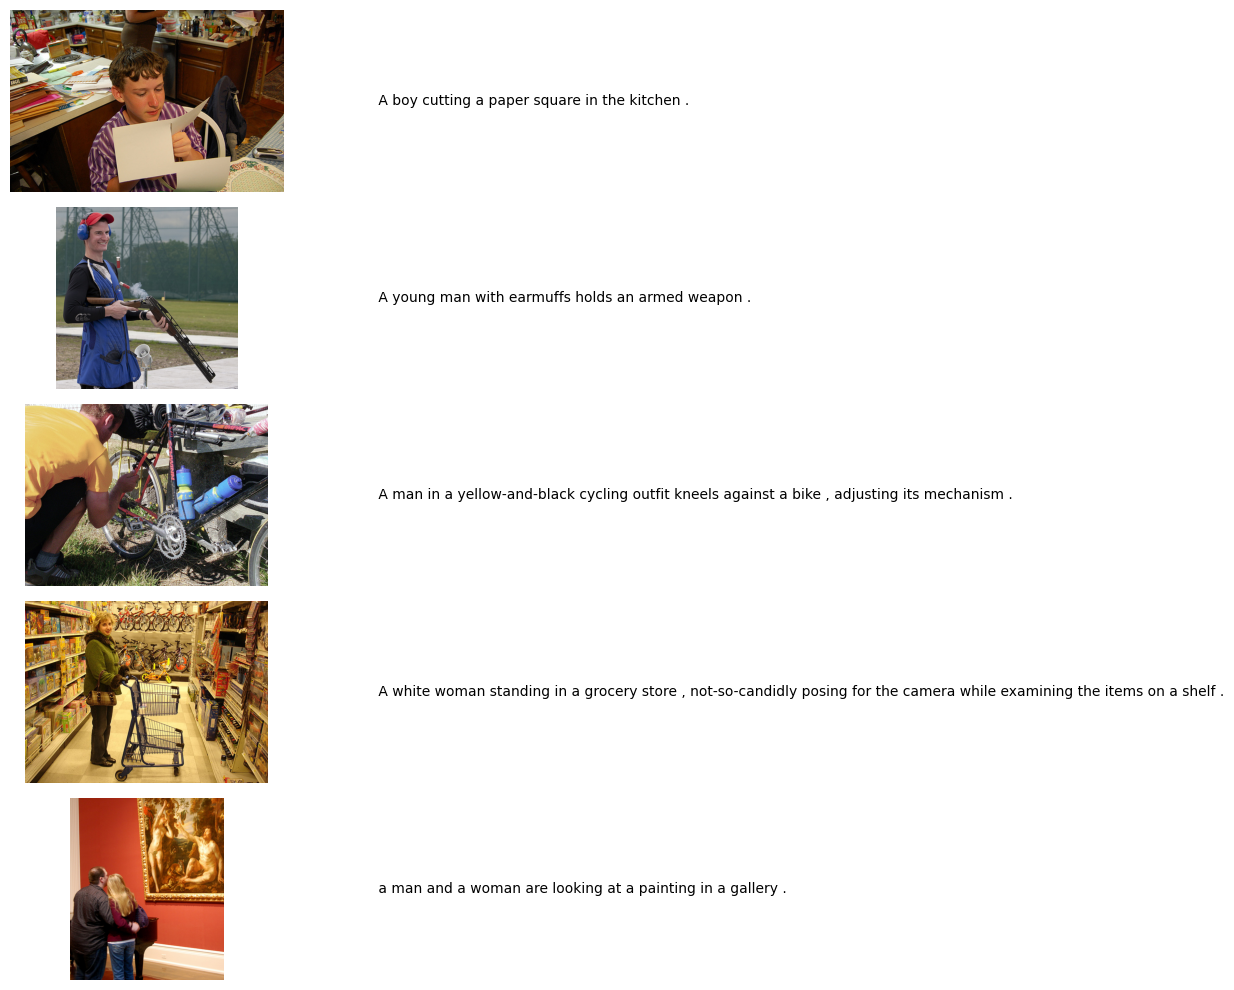

In [ ]:
import numpy as np

# Define the directory containing the images
images_dir = 'Images'

# Sample a few images from the dataset
sample_df = captions_df.sample(5)  # Adjust the sample size as needed

# Display images with captions
plt.figure(figsize=(15, 10))
for i, (img_id, caption) in enumerate(sample_df[['ImageID', 'Caption']].itertuples(index=False), 1):
    img_path = os.path.join(images_dir, f"{img_id}")
    img = Image.open(img_path)

    plt.subplot(5, 2, i * 2 - 1)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(5, 2, i * 2)
    plt.text(0, 0.5, f"{caption}", fontsize=10, ha='left', va='center', wrap=True)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Features Extraction Section

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.preprocessing.image import img_to_array, load_img
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import pickle

In [ ]:
def extract_features(directory):
    # Load the VGG16 model pre-trained on ImageNet
    base_model = VGG16(weights='imagenet')

    # Restructure the model to exclude the final classification layer
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

    # Summarize the model architecture
    print(model.summary())

    # Extract features from each photo
    features = {}
    onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]

    for name in tqdm(onlyfiles, desc="Extracting features"):
        try:
            # Load an image from file
            filename = join(directory, name)
            image = load_img(filename, target_size=(224, 224))

            # Convert the image pixels to a numpy array
            image = img_to_array(image)

            # Reshape data for the model
            image = image.reshape((1, *image.shape))

            # Prepare the image for the VGG model
            image = preprocess_input(image)

            # Get features from the specified layer (excluding the final classification layer)
            feature = model.predict(image, verbose=0)

            # Get image id
            image_id = name.split('.')[0]

            # Store feature
            features[image_id] = feature.flatten()
        except Exception as e:
            print(f'Error extracting features for {name}: {e}')

    return features

In [ ]:
# extract features from all images
directory = 'Images'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))

# Save features to file in Google Drive
drive_folder_path = '/content/drive/MyDrive/'  # Specify your desired folder path in Google Drive
with open(drive_folder_path + 'features.pkl', 'wb') as file:
    pickle.dump(features, file)

# Optionally, print the path to the saved file
print('Features saved to:', drive_folder_path + 'features.pkl')

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Extracting features:  38%|███▊      | 12142/31784 [12:36<18:31, 17.67it/s]

Error extracting features for results.csv: cannot identify image file <_io.BytesIO object at 0x7eada1666d40>


Extracting features: 100%|██████████| 31784/31784 [34:49<00:00, 15.21it/s]


Extracted Features: 31783
Features saved to: /content/drive/MyDrive/features.pkl


# Text Processing Section

In [ ]:
import string
from collections import defaultdict

In [ ]:
# Function to load text from a file
def load_doc(filename):
    with open(filename, 'r') as file:
        return file.read()

In [ ]:
# Function to load image descriptions from the document
def load_descriptions(doc):
    mapping = defaultdict(list)
    for line in doc.split('\n'):
        if len(line) < 2:
            continue
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        mapping[image_id].append(image_desc)
    return mapping

In [ ]:
# Function to clean descriptions (lowercase, remove punctuation, etc.)
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i].split()
            # Convert to lowercase, remove punctuation, and filter words
            desc = [word.lower().translate(table) for word in desc if len(word) > 1 and word.isalpha()]
            desc_list[i] = ' '.join(desc)

In [ ]:
# Function to create a vocabulary from descriptions
def to_vocabulary(descriptions):
    return set(word for key in descriptions.keys() for desc in descriptions[key] for word in desc.split())

In [ ]:
# Function to save descriptions to a file
def save_descriptions(descriptions, filename):
    lines = [f'{key};{desc}' for key, desc_list in descriptions.items() for desc in desc_list]
    file_path = '/content/drive/MyDrive/descriptions.txt'
    with open(file_path, 'w') as file:
        file.write('\n'.join(lines))

In [ ]:
# Load descriptions
filename = '/content/drive/MyDrive/captions.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc)

# Clean descriptions
clean_descriptions(descriptions)

# Save cleaned descriptions
save_descriptions(descriptions, 'descriptions.txt')

# Display vocabulary size
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size:', len(vocabulary))

Vocabulary Size: 17882


# LSTM-based Model for Prediction

In [55]:
import pickle
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding, concatenate
from keras.applications import VGG16
import re

In [3]:
with open('/content/drive/MyDrive/features.pkl', 'rb') as file:
    image_features = pickle.load(file)

In [56]:
def load_captions(file_path):
    caption_mapping = {}

    try:
        with open(file_path, 'r') as f:
            caption_data = f.readlines()

        for line in caption_data:
            # Split on both semicolon and comma
            parts = re.split(';|,', line.strip())

            # Check if the line has the expected format
            if len(parts) >= 2:
                img_id_str, caption = parts[0], parts[1]

                # Remove file extension if present
                img_id_str = img_id_str.replace('.jpg', '')

                # Check if the image ID is not empty
                if img_id_str.strip() != "":
                    try:
                        img_id = int(img_id_str)
                        caption_mapping[img_id] = caption.strip()
                    except ValueError:
                        print(f"Warning: Unable to convert image ID '{img_id_str}' to an integer. Skipping this entry.")
                else:
                    print(f"Warning: Image ID is empty - {line}. Skipping this entry.")
            else:
                print(f"Warning: Invalid line format - {line}. Skipping this entry.")

    except Exception as e:
        print(f"Error reading captions file: {e}")

    return caption_mapping


In [62]:
def preprocess_data(image_features, caption_mapping):
    train_ids = list(image_features.keys())[:8000]
    test_ids = list(image_features.keys())[8000:]

    train_idsc = list(caption_mapping.keys())[:8000]
    test_idsc = list(caption_mapping.keys())[8000:]

    train_images = [image_features.get(id) for id in train_ids if id in image_features]
    test_images = [image_features.get(id) for id in test_ids if id in image_features]

    train_captions = [caption_mapping.get(id) for id in train_idsc if id in caption_mapping]
    test_captions = [caption_mapping.get(id) for id in test_idsc if id in caption_mapping]

    # Debugging: Print the lengths and first few elements of train_captions
    print(f"Debugging: Length of train_captions: {len(train_captions)}")
    print(f"Debugging: First few elements of train_captions: {train_captions[:5]}")

    # Check if there are no valid training sequences
    if not train_images or not train_captions:
        print("Error: No valid training sequences found.")
        return None

    try:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(train_captions)
        vocab_size = len(tokenizer.word_index) + 1

        train_sequences = tokenizer.texts_to_sequences(train_captions)
        test_sequences = tokenizer.texts_to_sequences(test_captions)

        max_sequence_length = max(map(len, train_sequences)) if train_sequences else 0

        train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
        test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

        return train_images, test_images, train_sequences, test_sequences, vocab_size, max_sequence_length, tokenizer

    except Exception as e:
        print(f"Error during preprocessing: {str(e)}")
        return None


In [75]:
def captioning_model(vocab_size, max_sequence_length, feature_dim=4096):

    image_input = Input(shape=(feature_dim,))
    lstm_input = Input(shape=(max_sequence_length - 1,))

    image_input = Input(shape=(224, 224, 3))
    cnn_model = VGG16(weights='imagenet', include_top=False)
    cnn_output = cnn_model(image_input)

    flat_cnn_output = tf.keras.layers.Flatten()(cnn_output)

    lstm_input = Input(shape=(max_sequence_length-1,))
    embedding_layer = Embedding(vocab_size, 256, input_length=max_sequence_length-1)(lstm_input)
    lstm_layer = LSTM(256)(embedding_layer)

    merged = concatenate([flat_cnn_output, lstm_layer])

    output_layer = Dense(vocab_size, activation='softmax')(merged)

    model = Model(inputs=[image_input, lstm_input], outputs=output_layer)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [77]:
def train_model(model_lstm, train_images, train_sequences, epochs=10, batch_size=32):
    # Convert sequences to one-hot encoding
    y_train = tf.keras.utils.to_categorical(train_sequences, num_classes=vocab_size)

    # Train the model using model.fit
    model_lstm.fit([np.array(train_images), np.array(train_sequences[:, :-1])], y_train, epochs=epochs, batch_size=batch_size)

In [78]:
def evaluate_model(model_lstm, test_images, test_sequences):
    # Convert sequences to one-hot encoding
    y_test = tf.keras.utils.to_categorical(test_sequences, num_classes=vocab_size)

    # Evaluate the model using model.evaluate
    loss, accuracy = model_lstm.evaluate([np.array(test_images), np.array(test_sequences[:, :-1])], y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

In [72]:
caption_mapping = load_captions('/content/drive/MyDrive/captions.txt')
print(caption_mapping)
# Assuming you call preprocess_data somewhere in your code
preprocessed_data = preprocess_data(image_features, caption_mapping)

# Check if preprocess_data returned None before unpacking
if preprocessed_data is not None:
    train_images, test_images, train_sequences, test_sequences, vocab_size, max_sequence_length, tokenizer = preprocessed_data
else:
    print("Error: preprocess_data returned None.")


{1000092795: 'Two friends enjoy time spent together .', 10002456: 'Three men on a large rig .', 1000268201: 'A girl going into a wooden building .', 1000344755: 'a man on a ladder cleans a window', 1000366164: 'Two men are cooking a meal .', 1000523639: 'the two boys playing guitar', 1000919630: 'A man is smiling at a stuffed lion', 10010052: 'Woman talking on cellphone and wearing rollerskates .', 1001465944: 'Several people standing outside a building .', 1001545525: 'two guys jumping over a gate together', 1001573224: 'A ballet class of five girls jumping in sequence .', 1001633352: 'Four people are jumping from the top of a flight of stairs .', 1001773457: 'A black dog and a spotted dog are fighting', 1001896054: 'A man driving a John Deere tractor on a main road in the country .', 100197432: 'Women are standing outside', 100207720: 'A standing woman holds a pan over a cake .', 1002674143: 'Young girl with pigtails painting outside in the grass .', 1003163366: 'A man lays on a benc

In [ ]:
from keras.utils import to_categorical
# Create an instance of the model
model = captioning_model(vocab_size, max_sequence_length)

# Print model summary (optional)
model.summary()

# Assuming train_sequences are one-hot encoded and train_images are the corresponding image features
# Convert sequences to one-hot encoding
y_train = to_categorical(train_sequences, num_classes=vocab_size)

# Train the model
model.fit([np.array(train_images), np.array(train_sequences[:, :-1])], y_train, epochs=10, batch_size=32)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_28 (InputLayer)       [(None, 18)]                 0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_26[0][0]']            
                                                          8                                       
                                                                                                  
 embedding_7 (Embedding)     (None, 18, 256)              1097984   ['input_28[0][0]']      

In [ ]:
from keras.utils import to_categorical

# Evaluate the model (assuming you have test_images and test_sequences)
# Convert sequences to one-hot encoding for evaluation
y_test = to_categorical(test_sequences, num_classes=vocab_size)

# Evaluate the model
evaluation = model.evaluate([np.array(test_images), np.array(test_sequences[:, :-1])], y_test)

# Print the evaluation results
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])